In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import json

# plotting
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch

# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf

#opening data
import os
import pathlib
import warnings

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [2]:
path = os.path.join(str(pathlib.Path().resolve()), 'Data', 'Wyscout','events', 'events_England.json')

with open(path) as f:
    data = json.load(f)

train = pd.DataFrame(data)
train.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175


In [3]:
shots = train.loc[train['subEventName'] == 'Shot']

In [4]:
shots.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212
62,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'...",26150,"[{'y': 52, 'x': 85}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,179.854785,100,177959247
91,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",14763,"[{'y': 52, 'x': 96}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,254.745027,100,177959280
128,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",7868,"[{'y': 33, 'x': 81}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,425.824035,100,177959289
249,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'...",7868,"[{'y': 30, 'x': 75}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,815.462015,100,177959429


In [5]:
#get shot coordinates as separate columns
shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)
shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68/100)
shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)

#calculate distance and angle
shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)

#if you ever encounter problems (like you have seen that model treats 0 as 1 and 1 as 0) while modelling - change the dependant variable to object
shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)

## Plot Shot Location

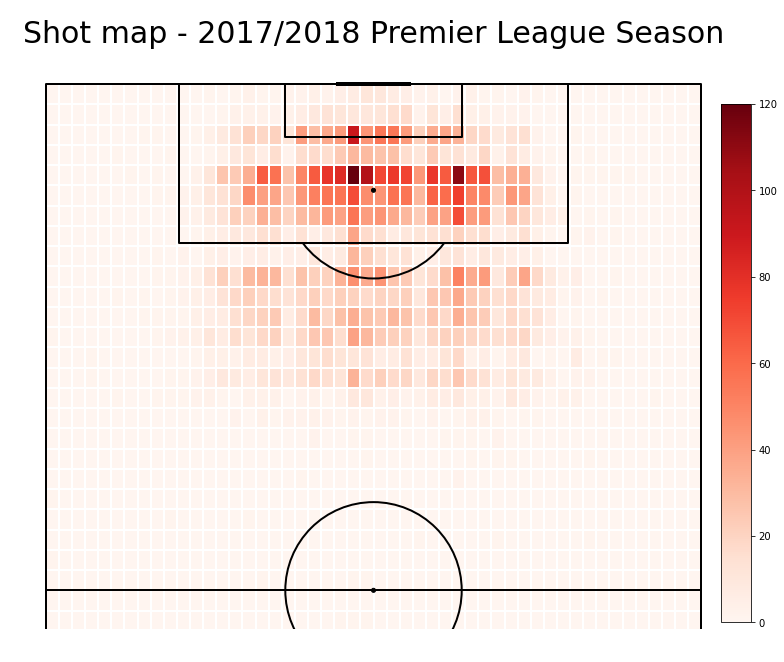

In [6]:
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#subtracting x from 105 but not y from 68 because of inverted Wyscout axis
#calculate number of shots in each bin
bin_statistic_shots = pitch.bin_statistic(105 - shots.X, shots.Y, bins=50)

#make heatmap
pcm = pitch.heatmap(bin_statistic_shots, ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth = 0.01)

#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot map - 2017/2018 Premier League Season' , fontsize = 30)
plt.show()

## Plot Goal Location

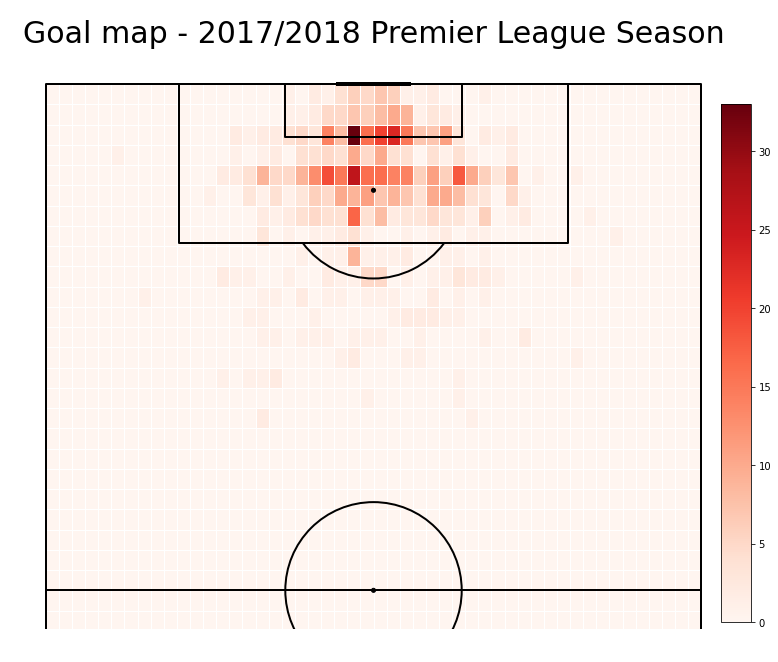

In [7]:
#take only goals
goals = shots.loc[shots["Goal"] == 1]

#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#calculate number of goals in each bin
bin_statistic_goals = pitch.bin_statistic(105 - goals.X, goals.Y, bins=50)

#plot heatmap
pcm = pitch.heatmap(bin_statistic_goals, ax=ax["pitch"], cmap='Reds', edgecolor='white')

#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal map - 2017/2018 Premier League Season' , fontsize = 30)
plt.show()

## Plotting the probability of scoring a goal given the location

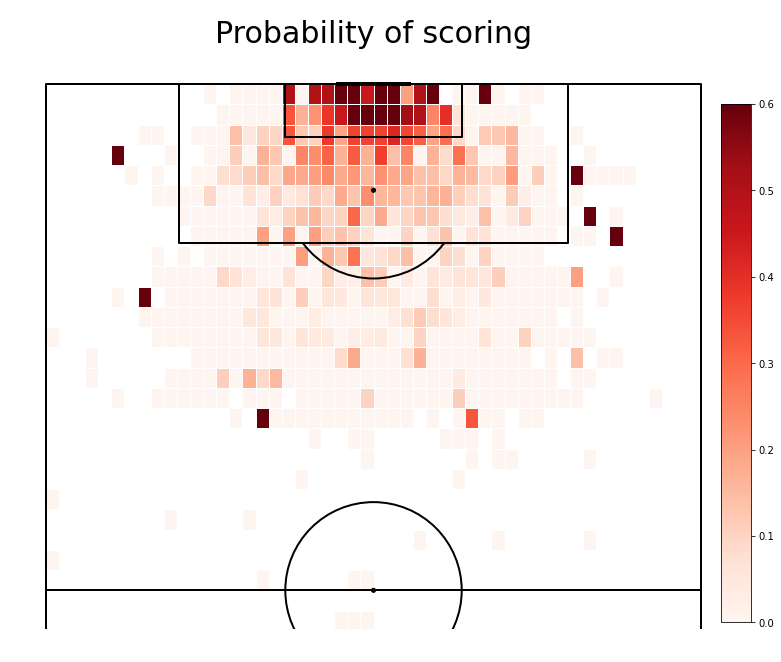

In [8]:
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
bin_statistic = pitch.bin_statistic(105 - shots.X, shots.Y, bins = 50)

#normalize number of goals by number of shots
bin_statistic["statistic"] = bin_statistic_goals["statistic"]/bin_statistic["statistic"]

#plot heatmap
pcm = pitch.heatmap(bin_statistic, ax=ax["pitch"], cmap='Reds', edgecolor='white', vmin = 0, vmax = 0.6)

#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Probability of scoring' , fontsize = 30)
plt.show()

## Plotting a logistic curve

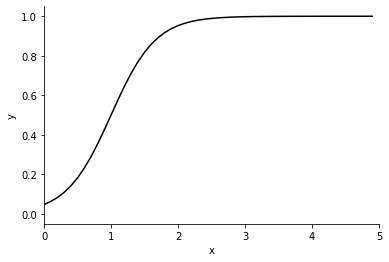

In [9]:
b = [3, -3]
x = np.arange(5, step=0.1)
y = 1/(1+np.exp(b[0]+b[1]*x))
fig,ax = plt.subplots()
plt.ylim((-0.05,1.05))
plt.xlim((0,5))
ax.set_ylabel('y')
ax.set_xlabel("x")
ax.plot(x, y, linestyle='solid', color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Investigating the relationship between probability of scoring goals and angle

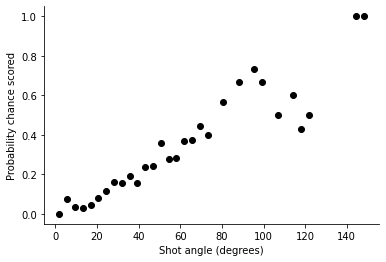

In [10]:
#number of shots from angle
shotcount_dist = np.histogram(shots['Angle']*180/np.pi, bins=40, range=[0, 150])

#number of goals from angle
goalcount_dist = np.histogram(goals['Angle']*180/np.pi, bins=40, range=[0, 150])
np.seterr(divide='ignore', invalid='ignore')

#probability of scoring goal
prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0])
angle = shotcount_dist[1]
midangle = (angle[:-1] + angle[1:])/2 # finds the midangle of each bin

#make plot
fig,ax = plt.subplots()
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Fitting logistic regression with random coefficients

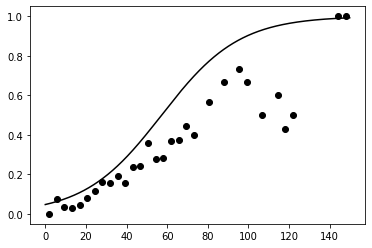

In [11]:
fig, ax = plt.subplots()
b = [3, -3]
x = np.arange(150,step=0.1)
y = 1/(1+np.exp(b[0]+b[1]*x*np.pi/180))
#plot line
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
#plot logistic function
ax.plot(x, y, linestyle='solid', color='black')
plt.show()

## Calculating log-likelihood

log likelihood a way to measure how well it fits to the data. More negative the number better the fit

In [12]:
#calculate xG
xG = 1/(1+np.exp(b[0]+b[1]*shots['Angle']))
shots = shots.assign(xG = xG)
shots_40 = shots.iloc[:40]
shots.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,X,Y,C,Distance,Angle,Goal,xG
46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,12.60,27.88,6.12,14.007655,0.467241,1,0.168222
62,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'...",26150,"[{'y': 52, 'x': 85}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,179.854785,100,177959247,15.75,35.36,1.36,15.808608,0.453557,0,0.162557
91,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",14763,"[{'y': 52, 'x': 96}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,254.745027,100,177959280,4.20,35.36,1.36,4.414703,1.375115,1,0.754979
128,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",7868,"[{'y': 33, 'x': 81}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,425.824035,100,177959289,19.95,22.44,11.56,23.057235,0.274666,0,0.101926
249,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'...",7868,"[{'y': 30, 'x': 75}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,815.462015,100,177959429,26.25,20.40,13.60,29.563872,0.219665,0,0.087783


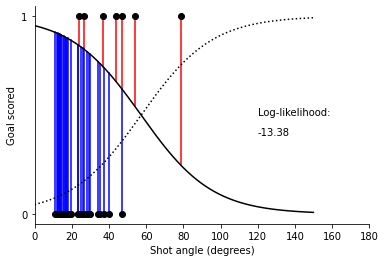

In [13]:
#plot data
fig, ax = plt.subplots()
ax.plot(shots_40['Angle']*180/np.pi, shots_40['Goal'], linestyle='none', marker= '.', markersize= 12, color='black', zorder = 3)
#plot curves
ax.plot(x, y, linestyle=':', color='black', zorder = 2)
ax.plot(x, 1-y, linestyle='solid', color='black', zorder = 2)
#calculate loglikelihood
loglikelihood=0
for item,shot in shots_40.iterrows():
    ang = shot['Angle'] * 180/np.pi
    if shot['Goal'] == 1:
        loglikelihood = loglikelihood + np.log(shot['xG'])
        ax.plot([ang,ang],[shot['Goal'],1-shot['xG']], color='red', zorder = 1)
    else:
        loglikelihood = loglikelihood + np.log(1 - shot['xG'])
        ax.plot([ang,ang], [shot['Goal'], 1-shot['xG']], color='blue', zorder = 1)
#make legend
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
plt.xlim((0,180))
plt.text(120,0.5,'Log-likelihood:')
plt.text(120,0.4,str(loglikelihood)[:6])
ax.set_yticks([0,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [14]:
#create model
test_model = smf.glm(formula="Goal ~ Angle" , data=shots,
                           family=sm.families.Binomial()).fit()
print(test_model.summary())

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8449
Model Family:                    Binomial   Df Model:                            1
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2561.2
Date:                    Mon, 22 Jan 2024   Deviance:                       5122.5
Time:                            09:10:53   Pearson chi2:                 7.96e+03
No. Iterations:                         6                                         
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

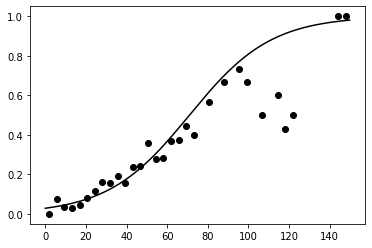

In [15]:
fig, ax = plt.subplots()
b = [3.5248, -2.8436 ]
x = np.arange(150,step=0.1)
y = 1/(1+np.exp(b[0]+b[1]*x*np.pi/180))
#plot line
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
#plot logistic function
ax.plot(x, y, linestyle='solid', color='black')
plt.show()

## Adding extra variables to the model

In [16]:
#creating extra variables
shots["X2"] = shots['X']**2
shots["C2"] = shots['C']**2
shots["AX"]  = shots['Angle']*shots['X']

# list the model variables you want here
model_variables = ['Angle','Distance','X','C', "X2", "C2", "AX"]
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]
model

'Angle + Distance + X + C + X2 + C2 + AX'

need to include the familiy argument so that glm knows that goals is a binary variable

In [17]:
#fit the model
test_model = smf.glm(formula="Goal ~ " + model, data=shots,
                           family=sm.families.Binomial()).fit()
#print summary
print(test_model.summary())
b=test_model.params
print(b)

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8443
Model Family:                    Binomial   Df Model:                            7
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2498.7
Date:                    Mon, 22 Jan 2024   Deviance:                       4997.4
Time:                            09:10:53   Pearson chi2:                 8.40e+03
No. Iterations:                         7                                         
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [28]:
def calculate_xG(sh):
    bsum = b[0]
    for i,v in enumerate(model_variables):
        bsum = bsum + b[i + 1] * sh[v]
    xG = 1 / (1 + np.exp(bsum))
    return xG


In [29]:
shots['xG'] = shots.apply(calculate_xG, axis = 1)
shots.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,X,Y,C,Distance,Angle,Goal,xG,X2,C2,AX
46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,...,12.60,27.88,6.12,14.007655,0.467241,1,0.110699,158.7600,37.4544,5.887234
62,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'...",26150,"[{'y': 52, 'x': 85}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,179.854785,...,15.75,35.36,1.36,15.808608,0.453557,0,0.096615,248.0625,1.8496,7.143529
91,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",14763,"[{'y': 52, 'x': 96}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,254.745027,...,4.20,35.36,1.36,4.414703,1.375115,1,0.484649,17.6400,1.8496,5.775484
128,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",7868,"[{'y': 33, 'x': 81}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,425.824035,...,19.95,22.44,11.56,23.057235,0.274666,0,0.039305,398.0025,133.6336,5.479587
249,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'...",7868,"[{'y': 30, 'x': 75}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,815.462015,...,26.25,20.40,13.60,29.563872,0.219665,0,0.023334,689.0625,184.9600,5.766201


#### Plotting xG model on pitch
Will create an 2D array iterating through each each position on the pitch calculating the necessary values for the function so the xG can be calculated at that point. 

In [31]:
pgoal_2d=np.zeros((68,68))
for x in range(68):
    for y in range(68):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-68/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-68/2)**2)
        sh['D2'] = x**2 + abs(y-68/2)**2
        sh['X'] = x
        sh['AX'] = x*a
        sh['X2'] = x**2
        sh['C'] = abs(y-68/2)
        sh['C2'] = (y-68/2)**2

        pgoal_2d[x,y] =  calculate_xG(sh)
        

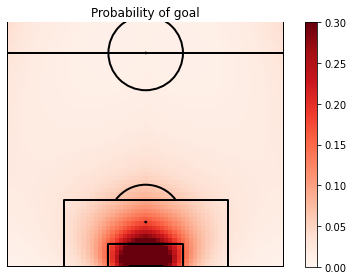

In [32]:
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.draw()
#plot probability
pos = ax.imshow(pgoal_2d, extent=[-1,68,68,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3, zorder = 1)
fig.colorbar(pos, ax=ax)
#make legend
ax.set_title('Probability of goal')
plt.xlim((0,68))
plt.ylim((0,60))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Evaluating Model

Plot an ROC curve to test the model on different thresholds

In [33]:
# ROC curve
numobs = 100
TP = np.zeros(numobs)
FP = np.zeros(numobs)
TN = np.zeros(numobs)
FN = np.zeros(numobs)

for i, threshold in enumerate(np.arange(0, 1, 1 / numobs)):
    for j, shot in shots.iterrows():
        if (shot['Goal'] == 1):
            if (shot['xG'] > threshold):
                TP[i] = TP[i] + 1
            else:
                FN[i] = FN[i] + 1
        if (shot['Goal'] == 0):
            if (shot['xG'] > threshold):
                FP[i] = FP[i] + 1
            else:
                TN[i] = TN[i] + 1

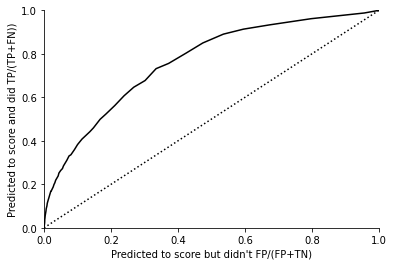

In [37]:
fig, ax = plt.subplots()
ax.plot(FP / (FP + TN), TP / (TP + FN), color='black')
ax.plot([0, 1], [0, 1], linestyle='dotted', color='black')
ax.set_ylabel("Predicted to score and did TP/(TP+FN))")
ax.set_xlabel("Predicted to score but didn't FP/(FP+TN)")
plt.ylim((0.00, 1.00))
plt.xlim((0.00, 1.00))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)